In [195]:
import os
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

import seaborn as sns


# Data Preprocessing

### Processing Pipeline

In [222]:


class Dropper(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(columns=self.feature_names)

class Normalizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = MinMaxScaler()

    def fit(self, X, y=None):
        self.numericalFeatures = X.select_dtypes(exclude='object').columns
        self.otherFeatures = X.columns.difference(self.numericalFeatures)
        self.scaler.fit(X[self.numericalFeatures])
        return self

    def transform(self, X):
        df_normalized = pd.DataFrame(self.scaler.transform(X[self.numericalFeatures]), columns=self.numericalFeatures)
        return pd.concat([df_normalized, X[self.otherFeatures]], axis=1)

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.ohEncoder = OneHotEncoder()

    def fit(self, X, y=None):
        self.categoricalFeatures = X.select_dtypes(include='object').columns
        self.otherFeatures = X.columns.difference(self.categoricalFeatures)
        self.ohEncoder.fit(X[self.categoricalFeatures])
        return self

    def transform(self, X):
        df_encoded = pd.DataFrame(self.ohEncoder.transform(X[self.categoricalFeatures]).toarray(), columns=self.ohEncoder.get_feature_names_out())
        return pd.concat([df_encoded, X[self.otherFeatures]], axis=1)


pipe = Pipeline([
    ('flightDrop', Dropper(['flight'])),
    # ('targetDrop', Dropper(['target'])),
    ('encoder', CategoricalEncoder()),
    ('scaler', Normalizer())
])

df = pd.read_csv(os.path.join('../archive', 'Clean_Dataset.csv'), index_col=0)
X = pipe.fit_transform(df)
print(X.columns)

Index(['airline_AirAsia', 'airline_Air_India', 'airline_GO_FIRST',
       'airline_Indigo', 'airline_SpiceJet', 'airline_Vistara',
       'source_city_Bangalore', 'source_city_Chennai', 'source_city_Delhi',
       'source_city_Hyderabad', 'source_city_Kolkata', 'source_city_Mumbai',
       'departure_time_Afternoon', 'departure_time_Early_Morning',
       'departure_time_Evening', 'departure_time_Late_Night',
       'departure_time_Morning', 'departure_time_Night', 'stops_one',
       'stops_two_or_more', 'stops_zero', 'arrival_time_Afternoon',
       'arrival_time_Early_Morning', 'arrival_time_Evening',
       'arrival_time_Late_Night', 'arrival_time_Morning', 'arrival_time_Night',
       'destination_city_Bangalore', 'destination_city_Chennai',
       'destination_city_Delhi', 'destination_city_Hyderabad',
       'destination_city_Kolkata', 'destination_city_Mumbai', 'class_Business',
       'class_Economy', 'days_left', 'duration', 'price'],
      dtype='object')


# EDA

The dataset used for this project was obtained from [mention source, e.g., Kaggle]. It contained the following key features:

- Airline: The carrier operating the flight.
- Source and Destination: Departure and arrival cities.
- Stops: Number of layovers.
- Duration: Total flight time.
- Departure and Arrival time.
- Price: The target variable representing the cost of the ticket.

Only 2 types of data: numerical and categorical.

In [ ]:
categories = {}
# nDf = pd.DataFrame()
for column in df.select_dtypes(include='object').columns:
    if column == 'flight':
        continue
    categories[column] = list(df[column].unique())
    # nDf = pd.concat([nDf, df[column].value_counts()])


print(df.describe())
print(categories)
# print(nDf)


            duration      days_left          price
count  300153.000000  300153.000000  300153.000000
mean       12.221021      26.004751   20889.660523
std         7.191997      13.561004   22697.767366
min         0.830000       1.000000    1105.000000
25%         6.830000      15.000000    4783.000000
50%        11.250000      26.000000    7425.000000
75%        16.170000      38.000000   42521.000000
max        49.830000      49.000000  123071.000000
Empty DataFrame
Columns: []
Index: []
{'airline': ['SpiceJet', 'AirAsia', 'Vistara', 'GO_FIRST', 'Indigo', 'Air_India'], 'source_city': ['Delhi', 'Mumbai', 'Bangalore', 'Kolkata', 'Hyderabad', 'Chennai'], 'departure_time': ['Evening', 'Early_Morning', 'Morning', 'Afternoon', 'Night', 'Late_Night'], 'stops': ['zero', 'one', 'two_or_more'], 'arrival_time': ['Night', 'Morning', 'Early_Morning', 'Afternoon', 'Evening', 'Late_Night'], 'destination_city': ['Mumbai', 'Bangalore', 'Kolkata', 'Hyderabad', 'Chennai', 'Delhi'], 'class': ['Economy

## Target Variable Analysis

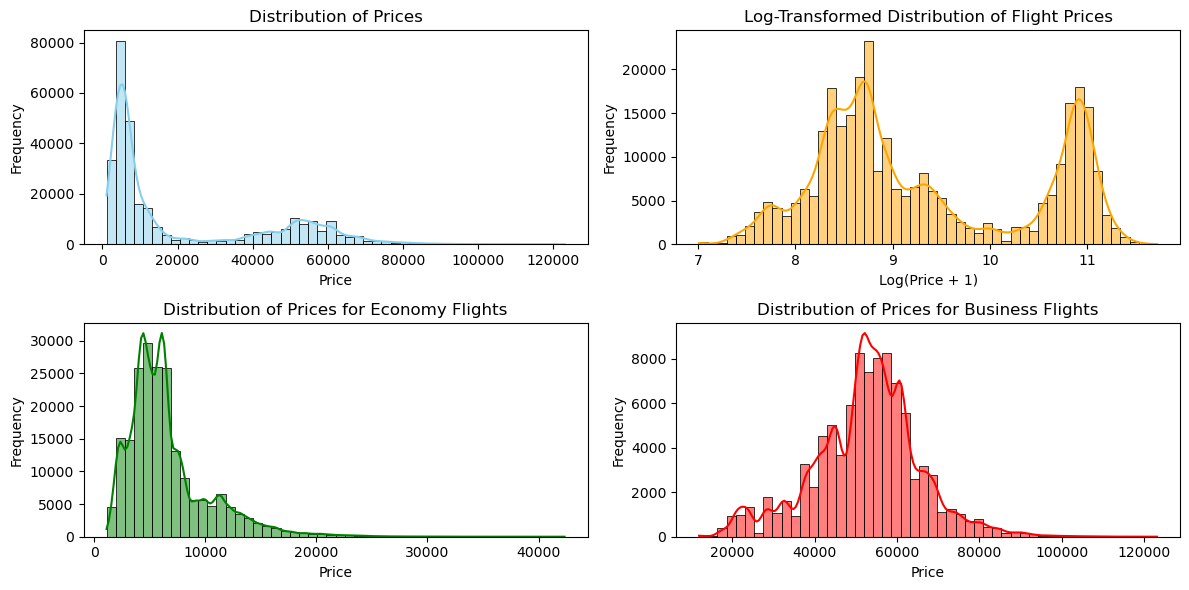

In [ ]:
economy_flights = df[df['class'] == 'Economy']
business_flights = df[df['class'] == 'Business']


fig, axes = plt.subplots(2, 2, figsize=(12, 6))
(ax1, ax2), (ax3, ax4) = axes  # Unpacking the axes correctly

sns.histplot(df['price'], bins=50, kde=True, color='skyblue', ax=ax1)
ax1.set_title("Distribution of Prices")
ax1.set_xlabel("Price")
ax1.set_ylabel("Frequency")

sns.histplot(np.log1p(df['price']), bins=50, kde=True, color='orange', ax=ax2)
ax2.set_title('Log-Transformed Distribution of Flight Prices')
ax2.set_xlabel('Log(Price + 1)')
ax2.set_ylabel('Frequency')

sns.histplot(economy_flights['price'], bins=50, kde=True, color='green', ax=ax3)
ax3.set_title("Distribution of Prices for Economy Flights")
ax3.set_xlabel("Price")
ax3.set_ylabel("Frequency")

sns.histplot(business_flights['price'], bins=50, kde=True, color='red', ax=ax4)
ax4.set_title("Distribution of Prices for Business Flights")
ax4.set_xlabel("Price")
ax4.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

Original prices are highly skewed on smaller values. 

The distribution shows a peak at lower prices, a long tail at higher prices, and a secondary hump at 40,000–70,000.

The log transformed data reduced skewness and compressed the long tail.

The price plot for the individual classes show a bell-shaped pattern.

### Correlation of target variable

In [ ]:
temp_X = df
correlation_matrix = temp_X.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)
print(correlation_matrix['price'].sort_values(ascending=False))

price               1.000000
class               0.800319
source_city         0.394763
flight              0.349651
duration            0.055816
departure_time      0.038114
stops               0.035080
destination_city    0.020832
airline            -0.001372
days_left          -0.007941
arrival_time       -0.016399
Name: price, dtype: float64


### Price Distribution by Class

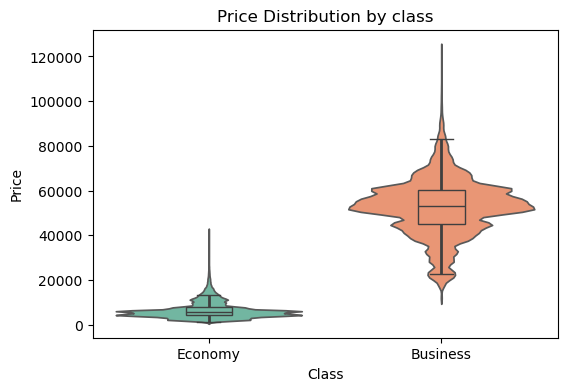

In [233]:

plt.figure(figsize=(6, 4))
sns.violinplot(x='class', y='price', data=df, inner=None, palette="Set2", hue='class')
sns.boxplot(x='class', y='price', data=df, 
            whis=1.5, width=0.2, showcaps=True, 
            boxprops={'facecolor':'none'}, 
            showfliers=False, whiskerprops={'linewidth':2})

plt.title('Price Distribution by class')
plt.xlabel('Class')
plt.ylabel('Price')
plt.show()




## Linear regression assumptions

### Linearity, Homoscedasticity

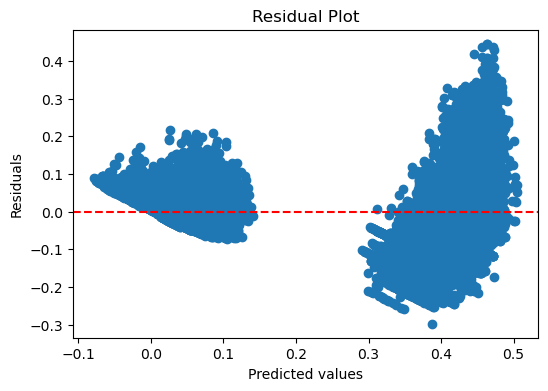

In [232]:
from sklearn.linear_model import LinearRegression

# X_temp = X[X['class_Economy'] == 1]
# X_temp = X[X['class_Business'] == 1]

X_temp = X
y = X_temp['price'].to_numpy().reshape(-1, 1)
X_temp = X_temp.drop(columns=['price'], axis=1)
train_X, val_X, train_y, val_y = train_test_split(X_temp, y, random_state=10, test_size=0.3)

model = LinearRegression()
model.fit(train_X, train_y)
y_pred = model.predict(val_X)

residuals = val_y - y_pred
plt.figure(figsize=(6, 4))
plt.scatter(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

### Multicollinearity

High Correlation Pairs: 
       Feature1     Feature2  Correlation
12       flight  source_city     0.941503
21  source_city       flight     0.941503


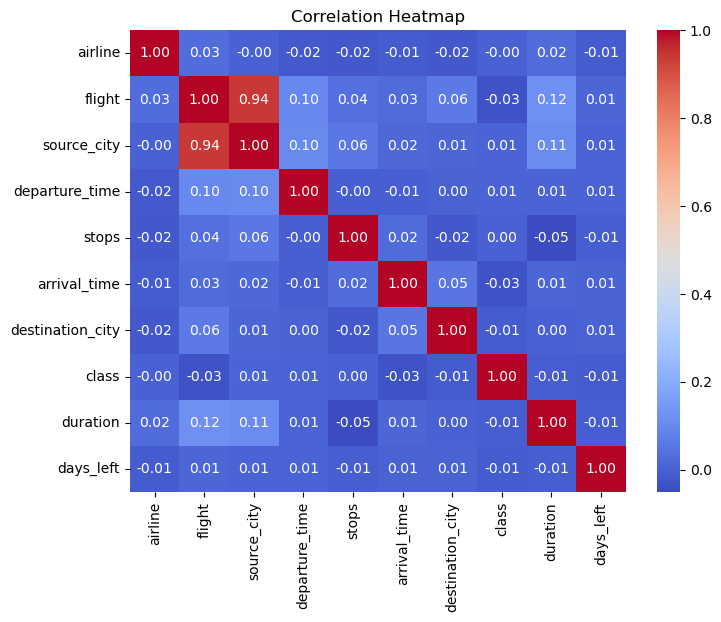

In [ ]:
temp_X = df
correlation_matrix = temp_X.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)
correlation_matrix.drop(index=correlation_matrix.index[-1], columns='price', inplace=True)

threshold = 0.8
corr_pairs = correlation_matrix.stack().reset_index()
corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']
high_corr_pairs = corr_pairs[((corr_pairs['Correlation'] > threshold) | (corr_pairs['Correlation'] < -threshold)) & (corr_pairs['Feature1'] != corr_pairs['Feature2'])]

print("High Correlation Pairs: ")
print(high_corr_pairs)


plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()



There is high correlation between flight name and source city.

## Feature Analysis

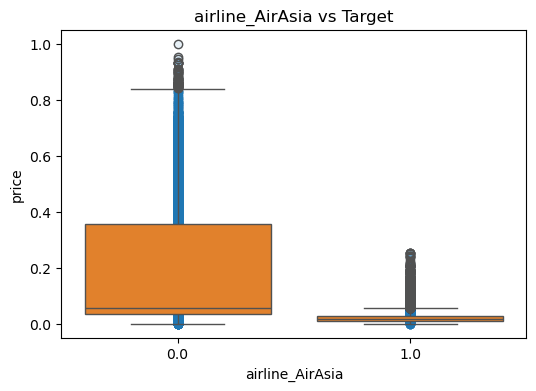

KeyboardInterrupt: 

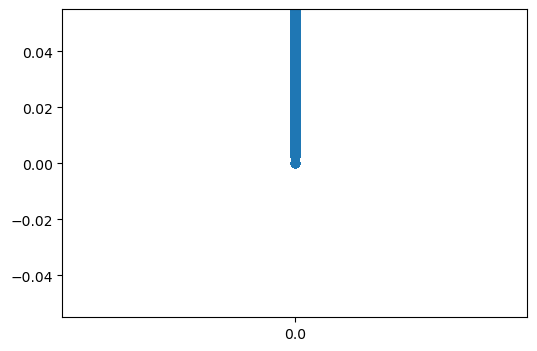

In [ ]:
import seaborn as sns

for feature in df.columns:
    plt.figure(figsize=(6, 4))
    # plt.scatter(x=X[feature], y=y)
    plt.scatter(x=X[feature], y=y, alpha=0.1)
    sns.boxplot(x=feature, y='price', data=X)
    plt.show()
    plt.title(f"{feature} vs Target")


The target variable is highly correlated with the flight class (Business or Economic)

### Airline

Vistara      127859
Air_India     80892
Indigo        43120
GO_FIRST      23173
AirAsia       16098
SpiceJet       9011
Name: airline, dtype: int64
0.6954819708615273


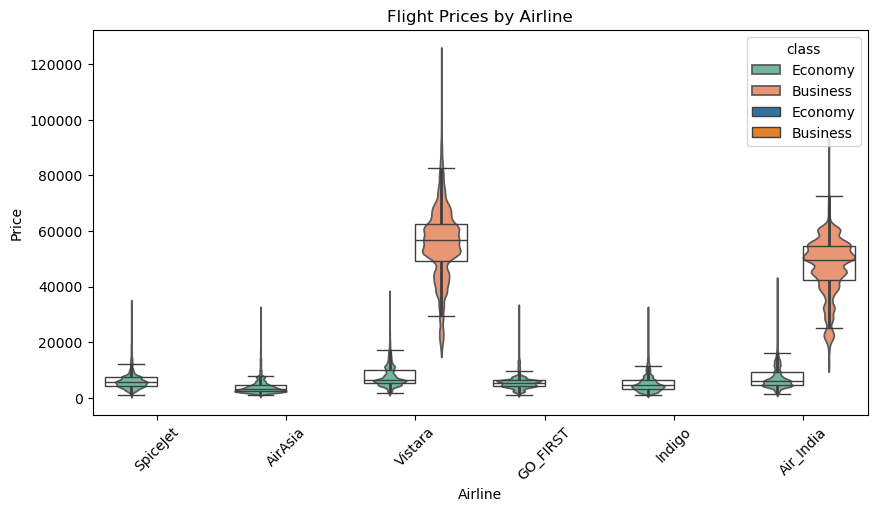

In [ ]:


print(df['airline'].value_counts())
airline_counts = dict(df['airline'].value_counts())
monopoly_ratio = ( airline_counts['Vistara'] + airline_counts['Air_India']) / sum(airline_counts.values())
# print(monopoly_ratio)
# print(business_flights['airline'].value_counts())
# print(economy_flights['airline'].value_counts())

plt.figure(figsize=(10,5))
sns.violinplot(x='airline', y='price', data=df, inner=None, palette="Set2", hue='class')
sns.boxplot(x='airline', y='price', data=df, 
            whis=1.5, width=0.8, showcaps=True, 
            boxprops={'facecolor':'none'}, 
            showfliers=False, whiskerprops={'linewidth':2}, hue='class')
plt.title('Flight Prices by Airline')
plt.xlabel('Airline')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.show()

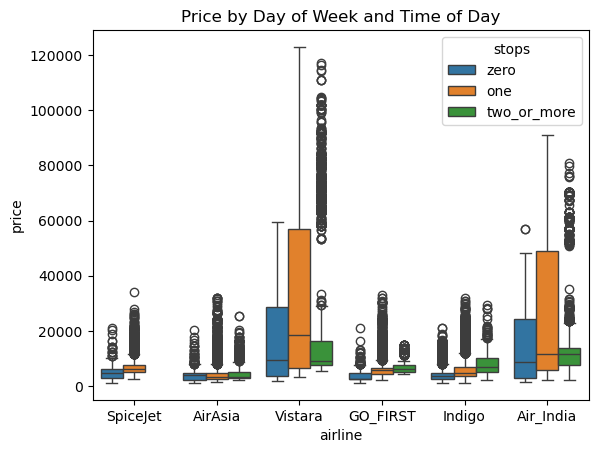

In [ ]:
sns.boxplot(x='airline', y='price', hue='stops', data=df)
plt.title('Price by Day of Week and Time of Day')
plt.show()

### Departure Time Analysis

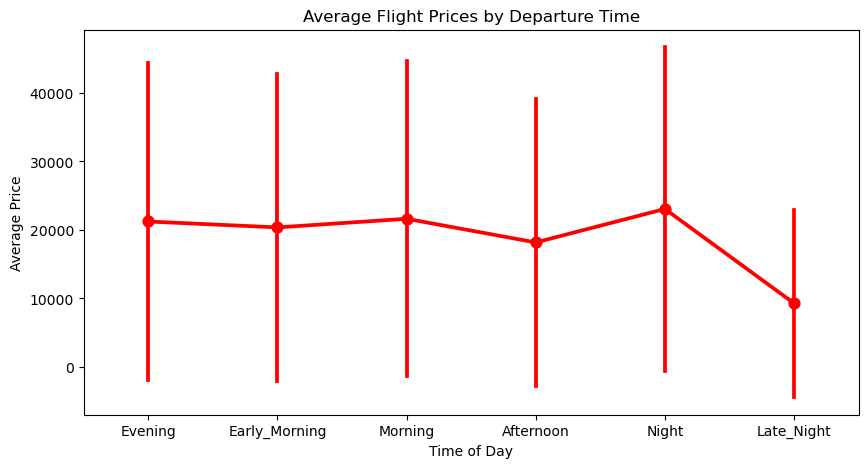

In [ ]:

plt.figure(figsize=(10, 5))
sns.pointplot(x='departure_time', y='price', data=df, errorbar='sd', color='red')
plt.title('Average Flight Prices by Departure Time')
plt.xlabel('Time of Day')
plt.ylabel('Average Price')
plt.show()

### Layover Analysis

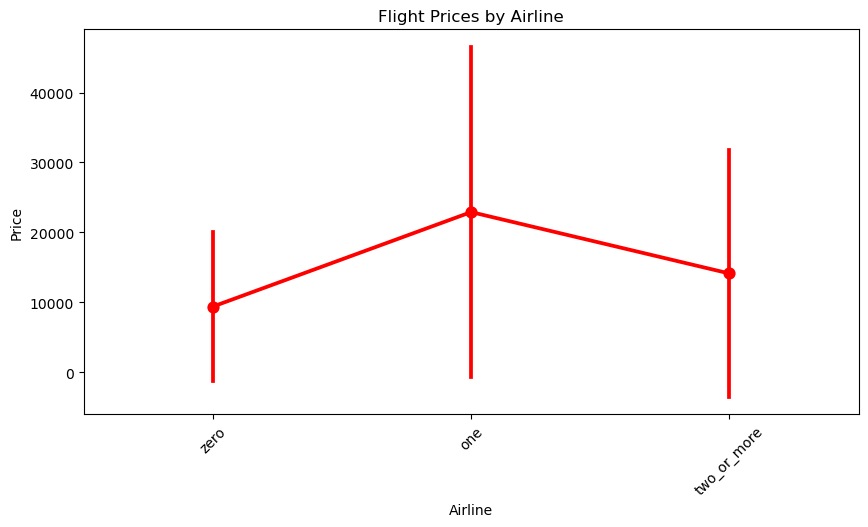

0.8357837502873534


one            250863
zero            36004
two_or_more     13286
Name: stops, dtype: int64

In [249]:
plt.figure(figsize=(10,5))
# sns.boxplot(x='stops', y='price', data=df)
sns.pointplot(x='stops', y='price', data=df, errorbar='sd', color='red')

plt.title('Flight Prices by Airline')
plt.xlabel('Airline')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.show()


stop_counts = dict(df['stops'].value_counts())
stop_ratio = ( stop_counts['one'] ) / sum(stop_counts.values())

print(stop_ratio)
df['stops'].value_counts()

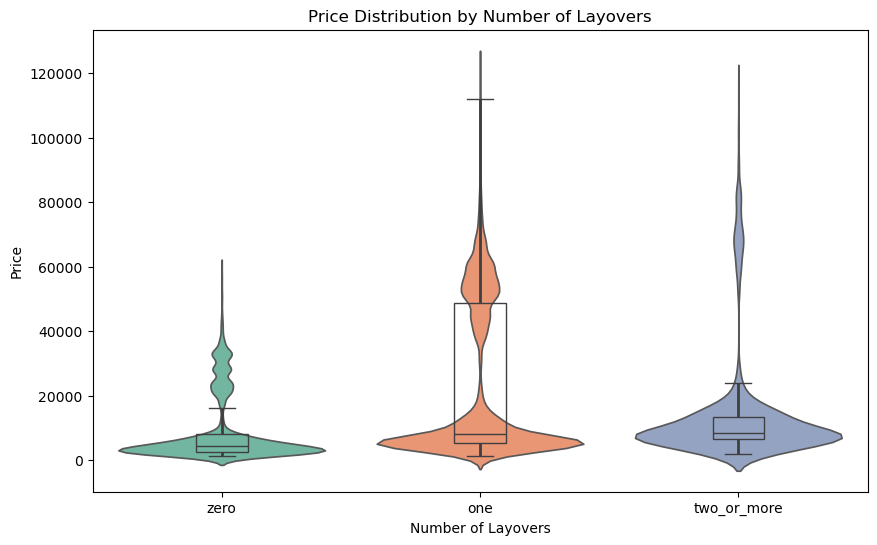

In [ ]:

plt.figure(figsize=(10, 6))
sns.violinplot(x='stops', y='price', data=df, inner=None, palette="Set2", hue='stops')
sns.boxplot(x='stops', y='price', data=df, 
            whis=1.5, width=0.2, showcaps=True, 
            boxprops={'facecolor':'none'}, 
            showfliers=False, whiskerprops={'linewidth':2})

plt.title('Price Distribution by Number of Layovers')
plt.xlabel('Number of Layovers')
plt.ylabel('Price')
plt.show()




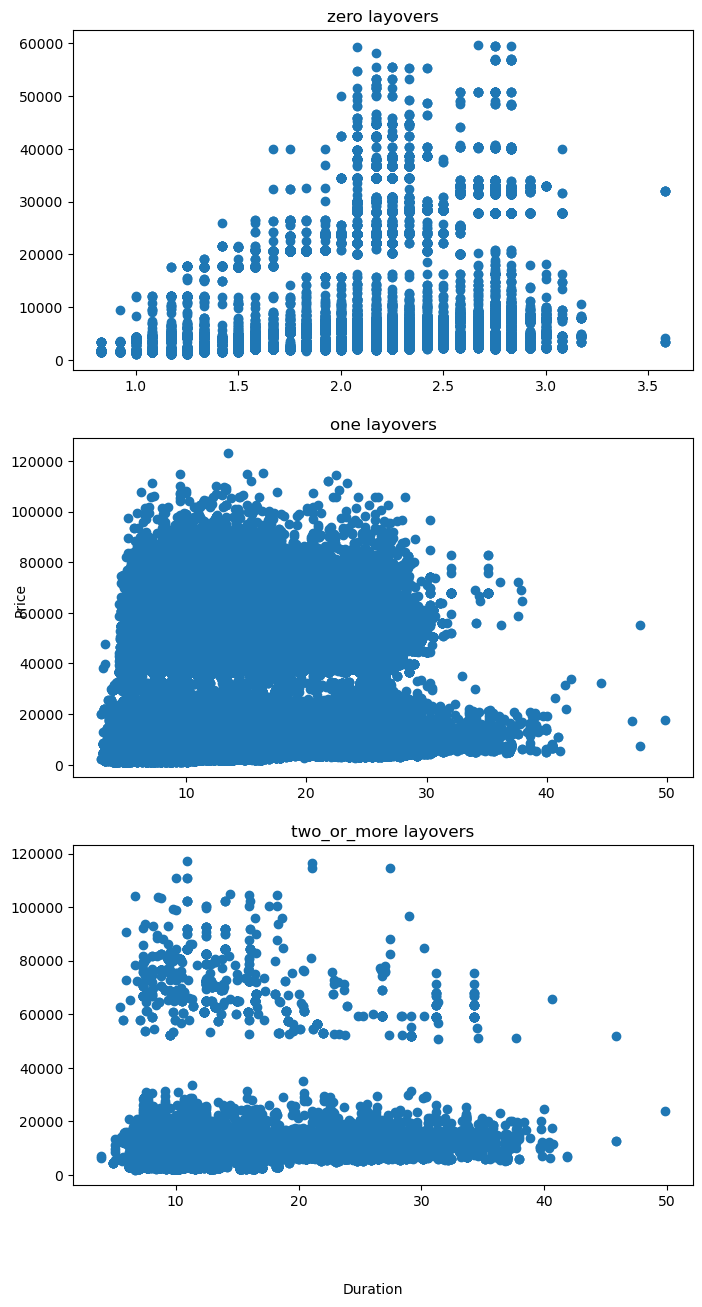

In [ ]:
# sns.scatterplot(x='duration', y='price', hue='stops', data=df, alpha=0.2)~

fig, ax = plt.subplots(3, 1, figsize=(8, 15))
fig.text(0.5, 0.04, 'Duration', ha='center', va='center')
fig.text(0.06, 0.5, 'Price', ha='center', va='center', rotation='vertical')


stops = df['stops'].unique()
n = len(stops)
for i, stop in enumerate(stops):
    one_stops = df[df['stops'] == stop]
    ax[i].scatter(x=one_stops['duration'], y=one_stops['price'])
    ax[i].set_title(f'{stop} layovers')
    # ax[i].title(f'Price vs. Duration for {stop} layovers')
    # aix[]lt.title('Price Distribution by class')

plt.show()

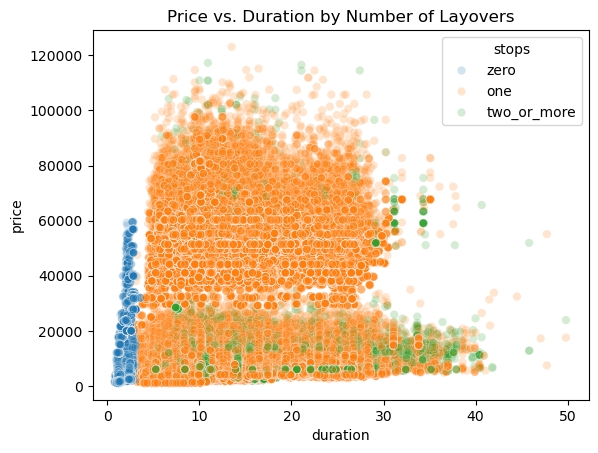

In [ ]:
sns.scatterplot(x='duration', y='price', hue='stops', data=df, alpha=0.2)
plt.title('Price vs. Duration by Number of Layovers')
plt.show()


## Outliers

<AxesSubplot: xlabel='price', ylabel='Count'>

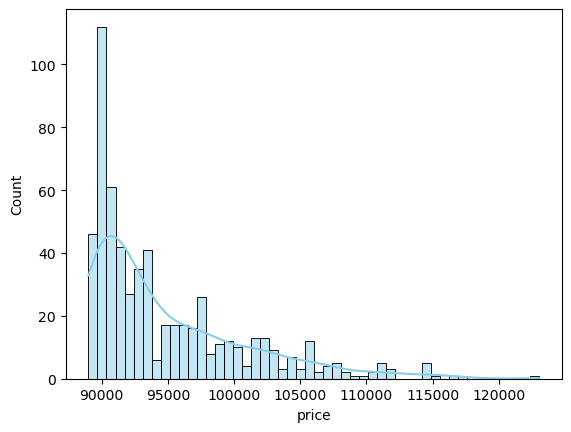

In [ ]:
from scipy import stats
df['Price_Z_Score'] = stats.zscore(df['price'])
outliers = df[abs(df['Price_Z_Score']) > 3]
high_price_outliers = df[df['Price_Z_Score'] > 3]
# print(sorted(high_price_outliers['days_left'].unique()))
# print(high_price_outliers['arrival_time'].value_counts())
# print(high_price_outliers['airline'].value_counts())
# print(high_price_outliers['airline'].value_counts())
# print(high_price_outliers['stops'].unique())
# plt.figure(figsize=(6, 3))
# sns.histplot(high_price_outliers['duration'], bins=50, kde=True, color='skyblue')
sns.histplot(high_price_outliers['price'], bins=50, kde=True, color='skyblue')
# plt.show()

All outlier flights are for **business** class.

The duration, days left, and times of departure and arrival **vary significantly**.

The flights have **one or more layovers**.

Almost all outliers are *from the same company*: Vistara.

This may be because of a few reasons:
- The company might offer premium services which other airlines don't. (No data to verify this.)
- It is one of few airlines serving these routes with a business class.

### Investigating Routes

Number of Vistara flights for outlier routes: 2409
Number of Other Airline flights for outlier routes: 29938


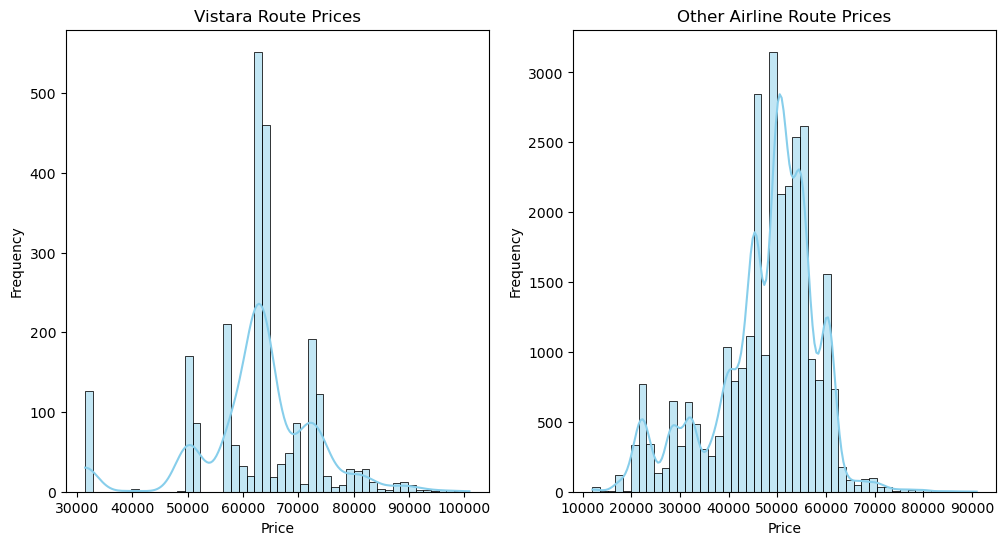

In [186]:

vistara_high = high_price_outliers[high_price_outliers['airline'] == 'Vistara']
all_combinations = vistara_high.groupby(['source_city', 'destination_city']).size().reset_index(name='count')

vistara_routes = pd.DataFrame()
route_flights = pd.DataFrame()
for index, row in all_combinations.iterrows():
    combos = list(row[['source_city', 'destination_city']])
    matching_rows = df[(df['source_city'] == combos[0]) & (df['destination_city'] == combos[1]) & (df['class'] == 'Business') & ~(df['airline'] == 'Vistara')]
    vistara_only = df[(df['source_city'] == combos[0]) & (df['destination_city'] == combos[1]) & (df['class'] == 'Business') & (df['airline'] == 'Vistara')]
    # print(matching_rows)
    route_flights = pd.concat([route_flights, matching_rows])
    vistara_routes = pd.concat([vistara_routes, vistara_only])


print("Number of Vistara flights for outlier routes:",  len(vistara_only))
print("Number of Other Airline flights for outlier routes:",  len(route_flights))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
sns.histplot(route_flights['price'], bins=50, kde=True, color='skyblue', ax=ax2)
ax2.set_title("Other Airline Route Prices")
ax2.set_xlabel("Price")
ax2.set_ylabel("Frequency")

sns.histplot(vistara_only['price'], bins=50, kde=True, color='skyblue', ax=ax1)
ax1.set_title("Vistara Route Prices")
ax1.set_xlabel("Price")
ax1.set_ylabel("Frequency")

plt.show()

The airline is <ins>not</ins> the only one serving those routes.

This behaviour may be the result of a dynamic pricing strategy; the airline being having "Premium" pricing and brand positioning.

In [189]:
low_price_outliers = df[df['Price_Z_Score'] < -3]
print(len(low_price_outliers))

0


Given the apparent clustering present in the plot, the relationship between the independent and dependent variables is non-linear.

# Conclusions


### Qualities
- The target variable is highly skewed -> should consider working with a log transformation.
- There are a lot more data points for some airlines (Vistara, Air India); and also a lot for number of layovers.
- These airlines probably have more flight schedules, as corroborated by their extreme price flighs, 
- The price distribution is very different depending on the class of the flight.

### Possible Explinations
- Reflects reality
- Could reflect reality, could also indicate Data collection bias, Market dominance


### Why it might me an issue
- if it is a data collection bias Can bias model

### Solutions
- resample the majority or minority airline classs; use Stratified Cross-Validation
- train different models for different layovers, different airlines.
- Treat business and economic class with different models.


